# Finetuning

To find a suitable model for your ML problem is very important. Not every model has the same performane on every task. Some models can be to simple (underfitting) and some models can be to complex for for a problem (overfitting). Also a model has different hyperparameters which also have an impact on the performance. Therefor exist libraries that can be used to find a appropriate model and its hyperparameters. Popular ones are [auto-sklearn](https://github.com/automl/auto-sklearn) and [hyperopt](https://github.com/hyperopt/hyperopt).

## Import packages

In [1]:
import sys

In [2]:
if 'google.colab' in sys.modules:
    ! git clone https://github.com/sdsc-bw/DataFactory.git
    ! ls
    
    !sudo apt-get install build-essential swig
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
    !pip install auto-sklearn
    
    !pip install scipy

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine, load_digits
from hyperopt import hp

if 'google.colab' in sys.modules:
    root = 'Datafactory/'
else:
    root = '../'
    
sys.path.insert(0, root + "codes")

from DataFactory import DataFactory

## Load dataset: MNIST digit dataset

In [5]:
X, y = load_digits(return_X_y=True)

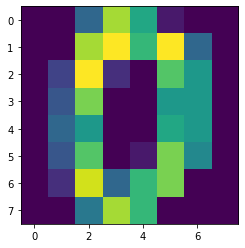

In [6]:
plt.imshow(X[0].reshape(8, 8))
plt.show()

## Use DataFactory

In [9]:
datafactory = DataFactory()

### Hyperopt

We also can provide a function to use hyperopt. It can be used the same way

In [17]:
# list with models to try out
models = ['decision_tree', 'random_forest', 'adaboost']
# list with params for every model to try out (search strategy of hyperparameters should be in ['parzen', 'random'])
params = {'strategy': 'random'}

In [18]:
model, score = datafactory.finetune(X, y, strategy='hyperopt', models=models, cv=3, mtype='C', params=params.copy())

2021-11-22 14:23:11,750 - DataFactory - INFO - Start finetuning...


100%|███████████████████████████████████████████████| 32/32 [00:18<00:00,  1.73trial/s, best loss: -0.9372110765409446]

2021-11-22 14:23:30,508 - DataFactory - INFO - ...End finetuning
2021-11-22 14:23:30,508 - DataFactory - INFO - Best model is: random_forest with parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [19]:
score

0.9372110765409446

If we want to define custom parameters, they should be defined with the functions of hyperopt.

In [20]:
models = ['decision_tree', 'random_forest', 'adaboost']
# attention the label has to be unique for every parameter (also between models)
params = {'strategy': 'random', 'decision_tree': {'max_depth': hp.quniform('max_depth_dt', 1, 10, 1), 'criterion': hp.choice('criterion_dt', ['gini', 'entropy']), 'min_samples_leaf': hp.choice('min_samples_leaf_dt', [1, 2, 4])}, 'random_forest': {'max_depth': hp.choice('max_depth_rf', [1, 2, 3, 5, 10, 20, 50]), 'n_estimators': hp.choice('n_estimators_rf', [50, 100, 200])}, 'adaboost': {'n_estimators': hp.choice('n_estimators_ab', [50, 100, 200]), 'learning_rate': hp.choice('learning_rate_ab', [0.001,0.01,.1,1.0])}}

In [21]:
model, score = datafactory.finetune(X, y, strategy='hyperopt', models=models, cv=5, mtype='C', params=params.copy())

2021-11-22 14:23:30,560 - DataFactory - INFO - Start finetuning...


100%|███████████████████████████████████████████████| 32/32 [00:42<00:00,  1.33s/trial, best loss: -0.9393121200815602]

2021-11-22 14:24:13,297 - DataFactory - INFO - ...End finetuning
2021-11-22 14:24:13,298 - DataFactory - INFO - Best model is: random_forest with parameters: {'max_depth': 50, 'n_estimators': 200}


In [22]:
score

0.9393121200815602

### Sklearn with Search

Sklearn also provides functions to tune the hyperparameters for a specific model. We implemented a function to also find the best model:

We can define the models that we want to test. Then we have to define a *param* variable that defines the strategy how to examine the search space. There we also can define the parameters of the search space. If parameters for models are not given, it uses the standard search space. Like we do it here:

In [11]:
# list with models to try out
models = ['decision_tree', 'random_forest', 'adaboost']

In [12]:
model, score = datafactory.finetune(X, y, strategy='sklearn', models=models, cv=5, mtype='C')

2021-11-22 14:22:54,705 - DataFactory - INFO - Start finetuning...
2021-11-22 14:22:54,706 - DataFactory - INFO - Start search for best parameters of: decision_tree...
2021-11-22 14:22:56,162 - DataFactory - INFO - ...End search
2021-11-22 14:22:56,162 - DataFactory - INFO - Best parameters are: {'min_samples_split': 9, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'entropy'} with score 0.88
2021-11-22 14:22:56,163 - DataFactory - INFO - Start search for best parameters of: random_forest...
2021-11-22 14:22:59,700 - DataFactory - INFO - ...End search
2021-11-22 14:22:59,701 - DataFactory - INFO - Best parameters are: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 50} with score 0.97
2021-11-22 14:22:59,701 - DataFactory - INFO - Start search for best parameters of: adaboost...
2021-11-22 14:23:03,845 - DataFactory - INFO - ...End search
2021-11-22 14:23:03,845 - DataFactory - INFO - Best parameters are: {'n_estimators': 200, 'learning_rate': 0.0

In [13]:
score

0.9711905101320953

Here we defined a custom search space:

In [14]:
# list with params for every model to try out (search strategy of hyperparameters should be in ['grid', 'random'])
params = {'strategy': 'random', 'decision_tree': {"criterion": ['gini', 'entropy'], "max_depth": range(1, 50), "min_samples_split": range(1, 20), "min_samples_leaf": range(1, 5)}, 'random_forest': {'max_depth': [1, 2, 3, 5, 10, 20, 50], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'n_estimators': [50, 100, 200]}, 'adaboost': {'n_estimators': [50, 100, 200], 'learning_rate':[0.001,0.01,.1]}}

In [15]:
model, score = datafactory.finetune(X, y, strategy='sklearn', models=models, cv=5, mtype='C', params=params)

2021-11-22 14:23:03,896 - DataFactory - INFO - Start finetuning...
2021-11-22 14:23:03,897 - DataFactory - INFO - Start search for best parameters of: decision_tree...
2021-11-22 14:23:04,099 - DataFactory - INFO - ...End search
2021-11-22 14:23:04,099 - DataFactory - INFO - Best parameters are: {'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 45, 'criterion': 'entropy'} with score 0.86
2021-11-22 14:23:04,100 - DataFactory - INFO - Start search for best parameters of: random_forest...
2021-11-22 14:23:07,561 - DataFactory - INFO - ...End search
2021-11-22 14:23:07,561 - DataFactory - INFO - Best parameters are: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 50} with score 0.97
2021-11-22 14:23:07,562 - DataFactory - INFO - Start search for best parameters of: adaboost...
2021-11-22 14:23:11,697 - DataFactory - INFO - ...End search
2021-11-22 14:23:11,697 - DataFactory - INFO - Best parameters are: {'n_estimators': 200, 'learning_rate': 0.

In [16]:
score

0.9659340954615522

### Auto-sklearn

Auto-sklearn requires a linux OS (otherwise it can be run on colab). It is an automated machine learning toolkit using sklearn models. It automatically trains different ML models with different hyperparameters. At the end it selects the best model. In the DataFactory you can use it like that:

In [10]:
model, score = datafactory.finetune(X, y, strategy='auto_sklearn', mtype='C')

In [ ]:
score